,date,item_sale
0,01.01.2013,1.362942e+06
1,01.01.2014,2.169291e+06
2,01.01.2015,2.893438e+06
3,01.02.2013,2.536633e+06
4,01.02.2014,4.150458e+06
...,...,...
1029,31.10.2013,3.519665e+06
1030,31.10.2014,3.167363e+06
1031,31.10.2015,3.184379e+06
1032,31.12.2013,1.211506e+07


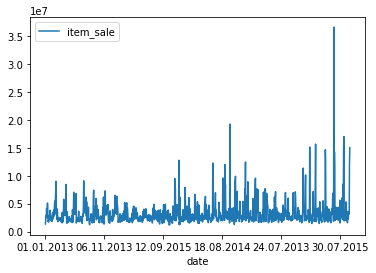

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import DataFrame

    
df1 = pd.read_csv('sales_train.csv')
df2 = pd.read_csv('items.csv')


#add a column named item_sale
df3 = pd.merge(df1,df2).drop('item_name', axis=1)
df3['item_sale'] = df3.item_price*df3.item_cnt_day

#drop the colums not needed
df4 = df3.drop(['date_block_num','shop_id','item_id','item_price','item_cnt_day','item_category_id'],axis=1)

#Groupby on date
df5 = df4.groupby('date')['item_sale'].sum().reset_index()



df5.plot(x='date',y='item_sale')
df5

In [2]:
#convert date to datetime format
df5['date']= pd.to_datetime(df5['date'])
#df5['month']=df5['date'].str.slice(3,)

df5['month'] = pd.to_datetime(df5['date']).dt.to_period('M')
df5['year'] = pd.DatetimeIndex(df5['date']).year

#add extra column to help get train and test data
df6 = df5.groupby('date')['item_sale'].sum().reset_index()
df6['year'] = pd.DatetimeIndex(df6['date']).year
df6 = df6.sort_values('date')

df6_train = df6[df6.year<2015]      
df6_test = df6[df6.year>2014]

X_train = df6_train['item_sale']

X_test = df6_test['item_sale'].reset_index()

X_test

,index,item_sale
0,730,2893438.00
1,731,3499096.59
2,732,3175882.01
3,733,1693925.20
4,734,2626787.23
...,...,...
299,1029,2616036.44
300,1030,2072214.98
301,1031,1441878.35
302,1032,3202689.34


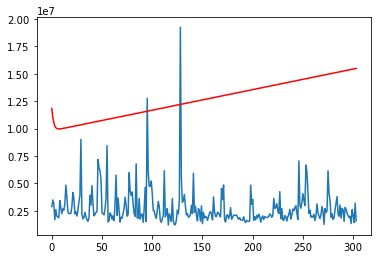

In [4]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(X_train, order=(3,1,1))
model_fit = model.fit()

predictions = model_fit.forecast(steps=304)[0]

plt.plot(X_test['item_sale'])
plt.plot(predictions, color='red')

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


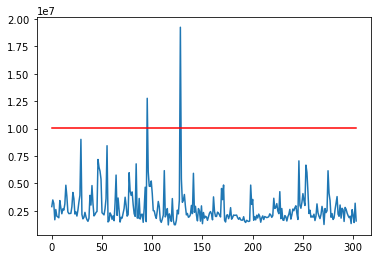

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model_ETS = SimpleExpSmoothing(np.asarray(X_train))
model_fit_ETS = model_ETS.fit(smoothing_level=.1)
pred1 = model_fit_ETS.forecast(304)
plt.plot(X_test['item_sale'])
plt.plot(pred1, color='red')

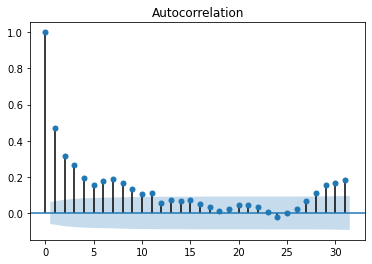

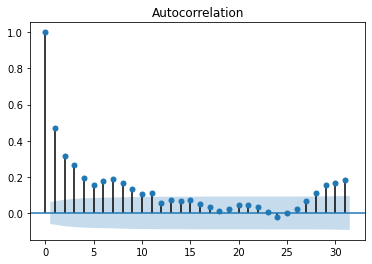

In [5]:
#stationarity test
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df6['item_sale'])

,date,item_sale,year,diff_sale,diff_sale1
0,2013-01-01,1362942.00,2013,0.00,0.00
1,2013-01-02,2536633.00,2013,1173691.00,29242519.00
2,2013-01-03,2518542.40,2013,-18090.60,28050737.40
3,2013-01-04,1823273.00,2013,-695269.40,27373558.60
4,2013-01-05,2727292.98,2013,904019.98,28972847.98


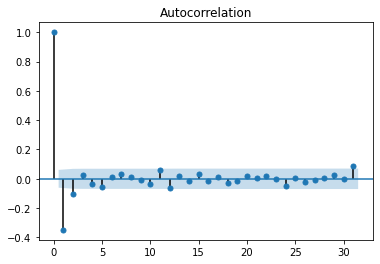

In [12]:
#stationarity test on transformed data
df6['diff_sale']=df6['item_sale']-df6['item_sale'].shift(1)

df6['diff_sale1']= df6['diff_sale']+28068828

plot_acf(df6['diff_sale'].dropna())
df6 = df6.fillna(0)
df6.head()

In [13]:
df6_train = df6[df6.year<2015]      
df6_test = df6[df6.year>2014]

#X_train_1 = df6_train['item_sale']

#X_test_1 = df6_test['item_sale'].reset_index()

#X_test_1.head()

df6_diff_train = df6_train['diff_sale1']
df6_diff_test = df6_test['diff_sale1'].reset_index()


#df6_diff_train = df6_diff_train.dropna()
df6_diff_train.head()
#df6_diff_test

0           0.00
1    29242519.00
2    28050737.40
3    27373558.60
4    28972847.98
Name: diff_sale1, dtype: float64

,diff_sale1
0,15940761.87
1,28674486.59
2,27745613.42
3,26586871.19
4,29001690.03
...,...
299,29334828.44
300,27525006.54
301,27438491.37
302,29829638.99


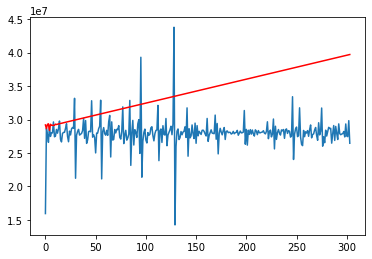

In [15]:
model_df6_diff = ARIMA(df6_diff_train, order=(4,1,0))
model_df6_diff_fit = model_df6_diff.fit()

pred_df6_diff = model_df6_diff_fit.forecast(steps=304)[0]

df6_diff_test = df6_diff_test.drop(['index'],axis=1)

plt.plot(df6_diff_test)
plt.plot(pred_df6_diff, color='red')
df6_diff_test

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


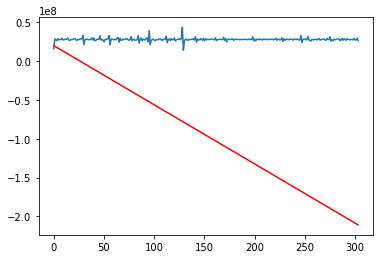

In [19]:
model1_diff_ETS = Holt(np.asarray(df6_diff_train))

model1_diff_ETS_fit = model1_diff_ETS.fit(smoothing_level=.01, smoothing_slope=.05)

pred2_diff = model1_diff_ETS_fit.forecast(304)

plt.plot(df6_diff_test)
plt.plot(pred2_diff, color='red')